In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from datetime import date
import lightgbm as lgb

/tmp/ipykernel_51095/2275341947.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
df_train_transaction = reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/train_transaction.csv', index_col='TransactionID'))
df_train_identity = reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/train_identity.csv', index_col='TransactionID'))

print(f'Shape of transaction train data: {df_train_transaction.shape}')
print(f'Shape of identity train data: {df_train_identity.shape}')

df_test_identity = reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/test_identity.csv', index_col='TransactionID'))
df_test_transaction = reduce_mem_usage(pd.read_csv('fraud-dataset-benchmark/tmp/test_transaction.csv', index_col='TransactionID'))


# # some columns (id) are wrongly labeled in test_identity. We will correct it
id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
df_test_identity = df_test_identity.rename(columns=rename_cols)


print(f'Shape of transaction train data: {df_test_transaction.shape}')
print(f'Shape of identity train data: {df_test_identity.shape}')

# #combining frames

df_train = df_train_transaction.merge(df_train_identity,on=['TransactionID'],how='left')

# # some columns (id) are wrongly labeled in test_identity. We will correct it
id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
df_test_identity = df_test_identity.rename(columns=rename_cols)
df_test = df_test_transaction.merge(df_test_identity,on=['TransactionID'],how='left')

# Assuming df_train is your DataFrame
missing_percentage = (df_train.isnull().sum() / len(df_train)) * 100
missing_percentage = missing_percentage.sort_values(ascending=False)

# Display missing percentage in descending order
missing_percentage.head(18)

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 489.41 MB
Decreased by 72.4%
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.55 MB
Decreased by 76.6%
Shape of transaction train data: (590540, 393)
Shape of identity train data: (144233, 40)
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 10.39 MB
Decreased by 76.6%
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 427.17 MB
Decreased by 71.9%
Shape of transaction train data: (506691, 392)
Shape of identity train data: (141907, 40)


id_24    99.196159
id_25    99.130965
id_08    99.127070
id_07    99.127070
id_21    99.126393
id_26    99.125715
id_27    99.124699
id_23    99.124699
id_22    99.124699
dist2    93.628374
D7       93.409930
id_18    92.360721
D13      89.509263
D14      89.469469
D12      89.041047
id_04    88.768923
id_03    88.768923
D6       87.606767
dtype: float64

In [9]:
# set the categorical columns to type 'category'

cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9' ,
            'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
# for cat in X_train.columns().tolist() - cat_cols:

    # X_train[cat] = X_train[cat].fillna(-999)
    # X_test = X_test.fillna(-999)

In [10]:
y_train = df_train['isFraud'].copy()


NameError: name 'df_train' is not defined

In [11]:

# Drop target, fill in NaNs
X_train = df_train.drop('isFraud', axis=1)
X_test = df_test.copy()

del df_train, df_test

NameError: name 'df_train' is not defined

In [9]:
# Check if categorical columns are categorical
for col in cat_cols:
    if col not in X_train.columns or not pd.api.types.is_categorical_dtype(X_train[col]):
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# Set the categories of categorical columns
for col in cat_cols:
    X_train[col] = X_train[col].cat.set_categories([-999] + X_train[col].cat.categories.tolist())
    X_test[col] = X_test[col].cat.set_categories([-999] + X_test[col].cat.categories.tolist())

# Fill in NaN values in categorical columns
X_train[cat_cols] = X_train[cat_cols].fillna(-999)
X_test[cat_cols] = X_test[cat_cols].fillna(-999)


lets forget the fillna for a second because it says set cateogrical first error 


In [26]:
# set the categorical columns to type 'category'

# cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9' ,
#             'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
# for cat in X_train.columns().tolist() - cat_cols:

    # X_train[cat] = X_train[cat].fillna(-999)
    # X_test = X_test.fillna(-999)

## One Hot

In [15]:
def one_hot_encoder_one(data,feature,keep_first=True):

    one_hot_cols = pd.get_dummies(data[feature])
    
    for col in one_hot_cols.columns:
        one_hot_cols.rename({col:f'{feature}_'+col},axis=1,inplace=True)
    
    new_data = pd.concat([data,one_hot_cols],axis=1)
    new_data.drop(feature,axis=1,inplace=True)
    
    if keep_first == False:
        new_data=new_data.iloc[:,1:]
    
    return new_data

In [16]:
X_one_hot_train=X_train.copy()
X_one_hot_test=X_test.copy()
for col in X_one_hot_train.select_dtypes(include='O').columns:
    X_one_hot_train=one_hot_encoder_one(X_one_hot_train,col)

for col in X_one_hot_test.select_dtypes(include='O').columns:
    X_one_hot_test=one_hot_encoder_one(X_one_hot_test,col)

## Label Encoding

In [10]:
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

## Target encoding


In [ ]:
from category_encoders.target_encoder import TargetEncoder

te_df=df.copy()
for col in te_df.select_dtypes(include='O').columns:
    te=TargetEncoder()
    te_df[col]=te.fit_transform(te_df[col],te_df.price)

## M-Estimate

In [ ]:
from category_encoders import MEstimateEncoder
feature_list = list(train.columns) # you can custumize later.
MEE_encoder = MEstimateEncoder()
train_mee = MEE_encoder.fit_transform(train[feature_list], target)
test_mee = MEE_encoder.transform(test[feature_list])

# Train Test split

In [19]:
x_train, x_val, y_train, y_val = train_test_split(X_one_hot_train[:], y_train[:], test_size=0.2, random_state=18)
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

ValueError: Found input variables with inconsistent numbers of samples: [590540, 472432]

In [12]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc',
          'learning_rate': 0.05, 'num_leaves': 200, 'num_iteration': 450, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':18, 'reg_alpha':.1, 'reg_lambda':.1,
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=60, verbose_eval=60)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.367813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 60 rounds
[60]	valid_0's auc: 0.958862
[120]	valid_0's auc: 0.969435
[180]	valid_0's auc: 0.973883
[240]	valid_0's auc: 0.976038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc: 0.977291
[360]	valid_0's auc: 0.977731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[420]	valid_0's auc: 0.978121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[450]	valid_0's auc: 0.978411


In [ ]:
from sklearn.metrics import roc_curve, auc

# Predict on the validation set
y_pred = model.predict(x_val)

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plot AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [20]:
from sklearn.metrics import roc_curve, auc

# Predict on the validation set
y_pred = model.predict(x_val)

# Calculate AUC
fpr_LE, tpr_LE, thresholds = roc_curve(y_val, y_pred)
roc_auc_LE = auc(fpr_LE, tpr_LE)

import pickle

# Create a dictionary to store the data
roc_data = {
    'fpr': fpr_LE,
    'tpr': tpr_LE,
    'roc_auc': roc_auc_LE
}

# Save the data to a file
with open('roc_data.pkl', 'wb') as file:
    pickle.dump(roc_data, file)


# Load the data from the file
with open('roc_data.pkl', 'rb') as file:
    roc_data = pickle.load(file)

# Access the loaded data
fpr = roc_data['fpr']
tpr = roc_data['tpr']
roc_auc = roc_data['roc_auc']


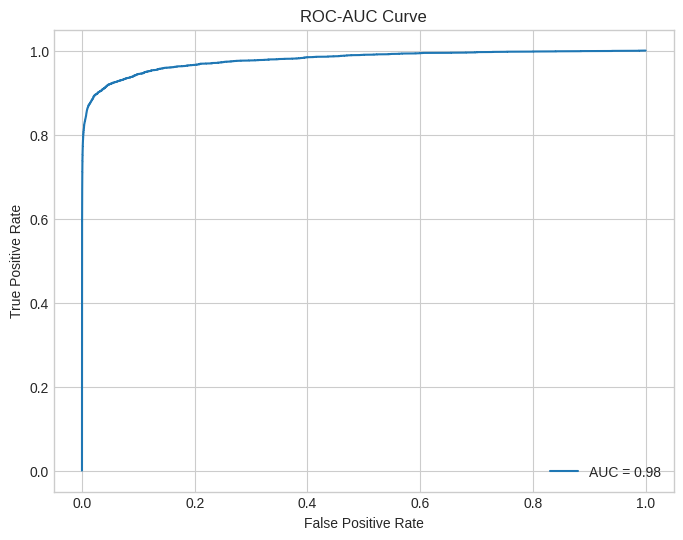

In [21]:
# Plot AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_LE, tpr_LE, label=f'AUC = {roc_auc_LE:.2f}')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()